In [2]:
import copy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.utils import load_data_template
from src.features.games import GameFeatures

In [98]:
data = load_data_template(season=False)
data.dropna(subset=['a_win'], inplace=True)
data.sample()

,Season,team_a,team_b,in_target,game_set,a_win,DayNum
10199,2002,1337,1448,False,0,False,136.0


In [99]:
game_feat = GameFeatures(default_lags=5)
data = game_feat.per_team_wrapper(data, game_feat.games_won_in_season, fillna=0)
data = game_feat.per_team_wrapper(data, game_feat.games_won_in_tourney, fillna=0)
data = game_feat.per_team_wrapper(data, game_feat.games_won_in_season_against_opponent, fillna=0, per_game=True)
data = game_feat.per_team_wrapper(data, game_feat.games_won_in_tourney_against_opponent, fillna=0, per_game=True)
data.sample()

,Season,team_a,team_b,in_target,game_set,a_win,DayNum,games_won_in_season_team_a,games_won_in_season_team_a_lag-1,games_won_in_season_team_a_lag-2,...,games_won_in_tourney_against_opponent_team_a_lag-1,games_won_in_tourney_against_opponent_team_a_lag-2,games_won_in_tourney_against_opponent_team_a_lag-3,games_won_in_tourney_against_opponent_team_a_lag-4,games_won_in_tourney_against_opponent_team_a_lag-5,games_won_in_tourney_against_opponent_team_b_lag-1,games_won_in_tourney_against_opponent_team_b_lag-2,games_won_in_tourney_against_opponent_team_b_lag-3,games_won_in_tourney_against_opponent_team_b_lag-4,games_won_in_tourney_against_opponent_team_b_lag-5
9875,1997,1229,1235,False,0,False,136.0,24,19.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
libfm_pred = pd.read_csv('data/libfm/model_out.csv', dtype={
    'team_a': str,
    'team_b': str,
    'Season': str
})
data = pd.merge(data, libfm_pred, on=['Season', 'team_a', 'team_b', 'DayNum'])\
    .rename(columns={'Pred': 'libfm_pred'})
data.head()

,Season,team_a,team_b,in_target,game_set,a_win,DayNum,games_won_in_season_team_a,games_won_in_season_team_a_lag-1,games_won_in_season_team_a_lag-2,...,games_won_in_tourney_against_opponent_team_a_lag-3,games_won_in_tourney_against_opponent_team_a_lag-4,games_won_in_tourney_against_opponent_team_a_lag-5,games_won_in_tourney_against_opponent_team_b_lag-1,games_won_in_tourney_against_opponent_team_b_lag-2,games_won_in_tourney_against_opponent_team_b_lag-3,games_won_in_tourney_against_opponent_team_b_lag-4,games_won_in_tourney_against_opponent_team_b_lag-5,ID,libfm_pred
0,2014,1107,1196,True,0,False,136.0,18,24.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014_1107_1196,0.513852
1,2014,1107,1291,True,0,True,134.0,18,24.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014_1107_1291,0.215372
2,2014,1110,1458,True,0,False,136.0,20,10.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014_1110_1458,0.893795
3,2014,1112,1211,True,0,True,139.0,30,25.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014_1112_1211,0.821133
4,2014,1112,1361,True,0,True,143.0,30,25.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014_1112_1361,0.563801


In [125]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss


X = data.drop(['Season', 'team_a', 'team_b', 'a_win', 'in_target', 'DayNum'], axis=1)
y = data[['a_win', 'game_set']]

kf = KFold(n_splits=3, shuffle=True)
metrics = []
for tr_i, t_i in kf.split(X):
    X_tr, y_tr = X.iloc[tr_i], y.iloc[tr_i].a_win
    X_t, y_t = X.iloc[t_i], y.iloc[t_i].a_win
    xgb = XGBClassifier(max_depth=2, n_estimators=250)
    xgb.fit(X_tr.values, y_tr)
    preds = xgb.predict_proba(X_t.values)
    ncaa_true = y.iloc[t_i][y.iloc[t_i].game_set == 0]
    ncaa_pred = preds[y.iloc[t_i].reset_index().game_set == 0]
    metric = log_loss(ncaa_true.a_win.astype(int), ncaa_pred)
    print(metric)
    metrics.append(metric)
    
print('Metric Mean: {:.2f} ({:.2f})'.format(np.mean(metrics), np.std(metrics)))

0.3795987324307758
0.4024982099473594
0.39433850707091617
Metric Mean: 0.39 (0.01)


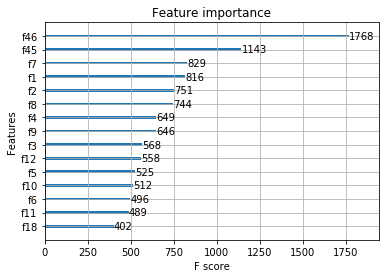

In [129]:
from xgboost import plot_importance

plt.figure(figsize=(20,4))
plot_importance(xgb, max_num_features=15)
plt.show()